## Preparatory scripts and data

This part of the document contains the preparatory scripts that load and preprocess data.
Read and execute the code snippets below before you work on any of the problems.

In [3]:
# Imports
import numpy as np
import random as rd
import matplotlib.pyplot as plt

In [4]:
# Utility functions
def normalize_mv(X, mu=None, sigma=None):
    """
    Normalizes input matrix X.
    If mu and sigma are provided, this function normalizes X using them.
    Otherwise, the function first estimates mu and sigma from X, and then normalizes X.
    Input: X - input matrix
           mu - a vector of column-wise mean values (can be omitted)
           sigma - a vector of column-wise standard deviation values (can be omitted)
    Output: 
    """
    if mu is None and sigma is None:
        mu = X.mean(axis=0)
        sigma = X.std(axis=0)
    return (X - mu)/sigma, mu, sigma


def get_accuracy(Y_true, Y_pred):
    """
    Measures the classification accuracy.
    Input: Y_true - true label vector (ground truth)
           Y_pred - predicted label vector
    return a floating point number representing accuracy
    """
    assert len(Y_true) == len(Y_pred)  # optional - assert makes sure a certain condition satisfies
    return np.sum(Y_true == Y_pred)/len(Y_true)
    

In [5]:
# Data prep.

# Step 1) Load raw data
data = np.genfromtxt('breast-cancer-wisconsin.csv', delimiter=',', skip_header=0)
# print(data)

# Step 2) Remove rows with missing values
data=data[~np.isnan(data).any(axis=1)]

# Step 3) Split data into X and y
X = data[:, 1:-1]
y = data[:, -1]

# Step 4) Create a 0/1 label vector 
y[y==2] = 0  # benign
y[y==4] = 1  # malignant

# Step 5) Split data into 90% (615 instances) of trainset (X_tr, y_tr) and
#        10% (68 instances) of testset (X_ts, y_ts)
N = data.shape[0]
N_tr = np.round(N*.9).astype(int)

X_tr = X[:N_tr, :]
y_tr = y[:N_tr]

X_ts = X[N_tr:, :]
y_ts = y[N_tr:]

print(X_tr.shape)
print(y_tr.shape)
print(X_ts.shape)
print(y_ts.shape)
# print(X_tr)
# print(X_ts)

# Step 6) Normalize the input attributes using your normalize() function
X_tr, mu_tr, sigma_tr = normalize_mv(X_tr)
X_ts, _, _ = normalize_mv(X_ts, mu_tr, sigma_tr)
# print(X_tr)
# print(X_ts)

N = X_tr.shape[0]
m = X_tr.shape[1]
print(m)

(615, 9)
(615,)
(68, 9)
(68,)
9


In [6]:
# Prepare data frames

import pandas as pd

X_tr_df = pd.DataFrame(X_tr, columns=['clump', 'u_cell_sz', 'u_cell_shp',
                                     'adhesion','se_cell_sz','nuclei',
                                     'chromatin','nucleioli','mitoses'])
y_tr_df = pd.Categorical(y_tr, categories=[0, 1])
# print(X_tr_df)
# print(y_tr_df)

X_tr_df.shape


(615, 9)

## Problem 1. Linear Discriminant Analysis (LDA)

**(b) Below provides a code skeleton for linear discriminant analysis. Complete the code such that it computes `S_w` and `S_b` as discussed in class.**

In [7]:
# Train LDA
# Getting per-class mean vectors
X_tr_stats = X_tr_df.join(pd.Series(y_tr_df, name='class'))
class_feature_means = pd.DataFrame(columns=[0,1])
for c, rows in X_tr_stats.groupby('class'):
    class_feature_means[c] = rows.mean(numeric_only=True)

    
# Computing the "within class" scatter
S_w = np.zeros((m, m))

## TODO: compute the "within class" scatter, S_w

for c, rows in X_tr_stats.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    mean_subtracted = rows-class_feature_means[c].values.reshape(1,-1)
    s = np.dot(mean_subtracted.T, mean_subtracted)
    print(mean_subtracted.shape)
    S_w += s


# Computing the "between classes" scatter
feature_means = X_tr_stats.mean(numeric_only=True)
S_b = np.zeros((m, m))
n_features = class_feature_means.shape[0]
column_length = len(X_tr_stats)

## TODO: compute the "between classes" scatter, S_b 
for c in class_feature_means.columns:
    n_c = len(X_tr_stats[X_tr_stats['class'] == c])

    mc = class_feature_means[c].values.reshape(n_features,1)
    m_1 = feature_means.values.reshape(n_features,1)

    S_b += column_length * (mc - m_1)@((mc - m_1).T)


print(pd.DataFrame(S_w))
print(pd.DataFrame(S_b))

# EVD
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(S_w).dot(S_b))
pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]
pairs = sorted(pairs, key=lambda x: x[0], reverse=True)

for pair in pairs:
    print(pair[0])



(389, 9)
(226, 9)
            0           1           2           3           4           5  \
0  298.315707   41.244621   46.234538  -12.488340   15.833233   -1.835958   
1   41.244621  212.374316  149.443251   79.462845  121.747891   17.315613   
2   46.234538  149.443251  205.738796   63.573498   99.087972   26.089239   
3  -12.488340   79.462845   63.573498  317.014606   68.888599   55.431366   
4   15.833233  121.747891   99.087972   68.888599  325.564094   15.885017   
5   -1.835958   17.315613   26.089239   55.431366   15.885017  194.340164   
6    7.851536   83.412027   71.865771   86.460470   60.264380   46.394064   
7   10.762675   80.850090   81.910439   62.777873   77.323333    5.872512   
8   30.502465   73.472742   57.632513   69.688808  114.377733   -4.620759   

            6           7           8  
0    7.851536   10.762675   30.502465  
1   83.412027   80.850090   73.472742  
2   71.865771   81.910439   57.632513  
3   86.460470   62.777873   69.688808  
4   60.2643

C:\Users\user\AppData\Local\Temp\ipykernel_29720\1516054539.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for c, rows in X_tr_stats.groupby('class'):
C:\Users\user\AppData\Local\Temp\ipykernel_29720\1516054539.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for c, rows in X_tr_stats.groupby('class'):


For your reference, the `S_w` and `S_b` matrices that I computed are provided below:

In [54]:
print(pd.DataFrame(S_w))
print(pd.DataFrame(S_b))

            0           1           2           3           4           5  \
0  298.315707   41.244621   46.234538  -12.488340   15.833233   -1.835958   
1   41.244621  212.374316  149.443251   79.462845  121.747891   17.315613   
2   46.234538  149.443251  205.738796   63.573498   99.087972   26.089239   
3  -12.488340   79.462845   63.573498  317.014606   68.888599   55.431366   
4   15.833233  121.747891   99.087972   68.888599  325.564094   15.885017   
5   -1.835958   17.315613   26.089239   55.431366   15.885017  194.340164   
6    7.851536   83.412027   71.865771   86.460470   60.264380   46.394064   
7   10.762675   80.850090   81.910439   62.777873   77.323333    5.872512   
8   30.502465   73.472742   57.632513   69.688808  114.377733   -4.620759   

            6           7           8  
0    7.851536   10.762675   30.502465  
1   83.412027   80.850090   73.472742  
2   71.865771   81.910439   57.632513  
3   86.460470   62.777873   69.688808  
4   60.264380   77.323333  11

**(c) After you complete and run your code for `S_w` and `S_b`, the following experiment should run with no problem. Excute the following code snippet and find the resulting figure. What does the figure represent? Explain in your own words.**

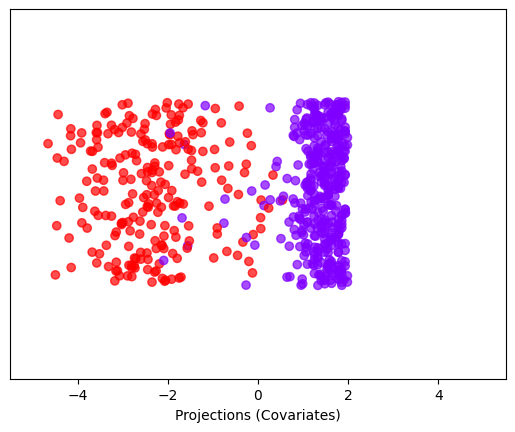

In [8]:
w = np.hstack((pairs[0][1].reshape(m,1))).real

y_tr_out = np.array(X_tr.dot(w))
y_ts_out = np.array(X_ts.dot(w))

# print(y_tr_out)
# print(y_ts_out)

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_code = le.fit_transform(X_tr_stats['class'])
plt.xlabel('Projections (Covariates)')
# plt.ylabel('')

plt.scatter(
    y_tr_out,
    np.random.rand(1,len(y_tr_out))/2 + .25,
    c=y_code,
    cmap='rainbow',
    alpha=0.7
)
plt.axis([-5.5, 5.5, 0, 1])
ax = plt.gca()
ax.axes.yaxis.set_visible(False)

In order to use the model (that is, the `w` vector) for prediction, one needs to determine the decision threshold. Namely, we would like to fix a value that determines all projected value above it fall in class 1; otherwise, class 0.


**(d) Write a script that finds the best threshold value from the training data. And then perform a prediction on the testing data and report the accuracy.**

In [9]:
# Problem 1 (d)
## TODO: Complete the snippet
def predict_with_threshold(y_out, threshold):
    return (y_out >= threshold).astype(int)

threshold_values = np.linspace(min(y_tr_out), max(y_tr_out), num=1000)
best_accuracy = 0
best_threshold = 0

for threshold in threshold_values:
    y_tr_pred = (y_tr_out >= threshold).astype(int)
    accuracy = get_accuracy(y_tr, y_tr_pred)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_threshold = threshold

y_ts_pred = (y_ts_out >= best_threshold).astype(int)
testing_accuracy = get_accuracy(y_ts, y_ts_pred)

print("best threshold :", best_threshold)
print("training accuracy:", best_accuracy)
print("testing accuracy:", testing_accuracy)

best threshold : 1.9432677637596694
training accuracy: 0.6260162601626016
testing accuracy: 0.8088235294117647


## Problem 2. Logistic Regression

**(a) Implement the sigmoid function.**

In [7]:
# Problem 2 (a)
def sigmoid(z):
    # TODO: Complete the function such that 
    return 1 / (1 + np.exp(-z))

Upon completion, you should see a nice sigmoid curve after running the following code.

(-8.0, 8.0)

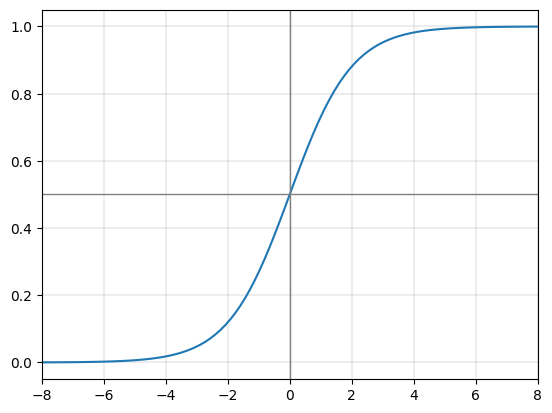

In [23]:
# visualizing the sigmoid function
z = np.linspace(-8,8,101)
v = sigmoid(z)  ## Your function is invoked

plt.plot(z, v)
plt.axvline(c='grey', lw=1)
plt.axline((-8, 0.5), (8, 0.5), c='grey', lw=1)

plt.grid(color='grey', linestyle='-', linewidth=.2)

plt.ylim(-0.05, 1.05)
plt.xlim(-8, 8)

**(c) Complete the `gradient_descent()` function such that it properly update w on each iteration.**

In [258]:
# Problem 2 (b-c)
def compute_cost(X, y, w):
    N = len(y)
    z = sigmoid(X @ w)
    epsilon = 1e-5
    cost = (1/N)*(((-y).T @ np.log(z + epsilon))-((1-y).T @ np.log(1-z + epsilon)))
    return cost


def gradient_descent(X, y, w, alpha, n_iters, threshold=1e-07):
    N = len(y)
    log_j = []
    j_last = np.Inf

    for i in range(n_iters):
        ## TODO: Complete the next line such that w_new have the updated weight values
        
        w_new = w - (-alpha/N * X.T @ (y - sigmoid(X @ w)))
         
        j_new = compute_cost(X, y, w)
        
        if j_last - j_new < threshold:
            break
        
        w = w_new
        log_j.append(j_new)
        j_last = j_new

    return w, log_j

Your compelete `gradient_descent()` should run with the following `train_logreg()` function.

In [250]:
# Problem 2 supplements: Additional function(s) required for this assignment
def train_logreg(X_tr, y_tr, alpha, n_iters=1500):
    """
    train_logreg
    Input: X_tr - Training input attributes
           y_tr - Training target labels
           n_iters - number of iterations (default: 1500)
    Output: w_star - trained model weights
            log_j - cost history
    """
    N_tr, d_tr = X_tr.shape
    
    X_tr_b = np.hstack((X_tr, np.ones((N_tr, 1))))
    w_init = np.zeros(d_tr + 1)  # np.random.rand(d_tr + 1)
    
    initial_cost = compute_cost(X_tr_b, y_tr, w_init)
    print("Initial J(w_init, D_tr) is: ", initial_cost, "\n")
    
    w_star, log_j = gradient_descent(X_tr_b, y_tr, w_init, alpha, n_iters)
    
    print("w*: \n", w_star, "\n")
    print("J(w*, D_tr): ", log_j[-1])
    
    return w_star, log_j

**(e) Implement `predict_logreg(X, w)` that takes an input matrix (X) and a weight vector (w). The function returns the 0/1 predictions and estimated probability P(y=1|x) for the input instances.**

In [57]:
def predict_logreg(X, w):
    """
    predict_logreg
    Input: X - Input attributes to predict the target output
           w - Trained model weights
    Output: y_pred - predicted target labels {0, 1}
            y_prob - estimated conditional probability P(y=1|x)
    """
    
    ## TODO: Complete this function

    N_tr, d_tr = X.shape
    X = np.hstack((X, np.ones((N_tr, 1))))
    
    y_prob = sigmoid(X @ w)
    
    y_pred = np.round(y_prob).astype(int)
    
    return y_pred

All in all, your complete code should run in the next experiment. A correct implementation would result in the accuracy evaluated on the breast cancer dataset much higher than 0.9.

In [259]:
# Experiment with LogReg (continued after the data preparation steps - the thrid code cell from the top)

# Step 7) Train a logReg model
Model_logreg, log_j_logreg = train_logreg(X_tr, y_tr, 0.005, 3000)


# Step 8) Apply the trained LogReg model for prediction on both X_tr and X_ts
y_tr_pred = predict_logreg(X_tr, Model_logreg)
y_ts_pred = predict_logreg(X_ts, Model_logreg)

# Step 9) Measure the accuracy on y_tr and y_ts, respectively,
#        using your get_accuracy function.
print(get_accuracy(y_tr, y_tr_pred))
print(get_accuracy(y_ts, y_ts_pred))

Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.69791806  0.60148189  0.65545492  0.5296396   0.46322818  0.82592807
  0.60273484  0.5292748   0.36595843 -0.45764689] 

J(w*, D_tr):  0.0962007329581487
0.9707317073170731
0.9852941176470589


**(f) Read the results. What are your accuracy on the training data and that of the testing data?**

**(g) Variable `log_j_logreg` contains the loss evaluated on each training iteration. Visualizing this variable highlights the progression of training. Plot the changes recorded in `log_j_logreg`; that is, x-axis is the iteration number, and y-axis is the output of the J function.**

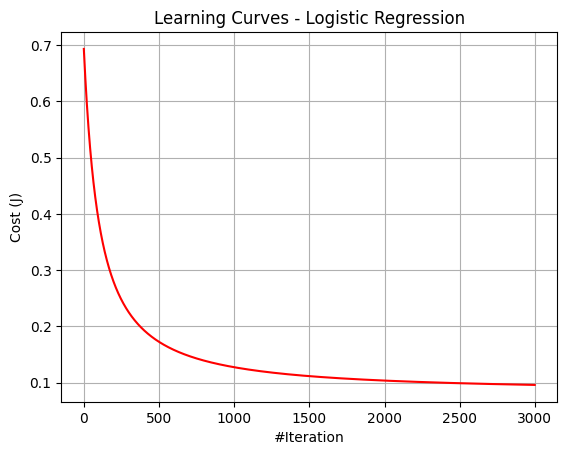

In [232]:
## TODO: Plot the chnages recorded in log_j_logreg (a.k.a. learning curve)
import matplotlib.pyplot as plt

plt.plot(range(len(log_j_logreg)), log_j_logreg, 'r')
plt.title('Learning Curves - Logistic Regression')
plt.xlabel('#Iteration')
plt.ylabel('Cost (J)')
plt.grid(True)
plt.show()

**EXTRA CREDIT: (h) Implement the L2-regularized logistic regression and repeat the above experiment. After finishing implementation, adjust `lambda`, that determines the influence of the regularizer, and repeat the experiments to acquire the best test result. You may also adjust `learning rate` and `n_iters`(#epochs) to improve the results.**

0
Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.20785852  0.22267033  0.22673136  0.19106711  0.18507334  0.24373198
  0.20670849  0.19454889  0.11131566 -0.10974528] 

J(w*, D_tr):  0.27843068483375233
Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.30869408  0.32166623  0.33015506  0.27612139  0.2646231   0.36565186
  0.30064653  0.28112236  0.16135495 -0.17985445] 

J(w*, D_tr):  0.19356618958046726
Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.37593453  0.3835368   0.39628994  0.32955249  0.31316113  0.44782006
  0.36065965  0.33525525  0.19487876 -0.22908268] 

J(w*, D_tr):  0.15840594234402675
Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.42688776  0.42758274  0.44440198  0.36786034  0.34690941  0.51009501
  0.40440805  0.37382726  0.22061475 -0.26672101] 

J(w*, D_tr):  0.1394592523798368
Initial J(w_init, D_tr) is:  0.6931271807599426 

w*: 
 [ 0.46837034  0.46134548  0.48205398  0.39748731  0.37216396  0.56050836
  0.438784

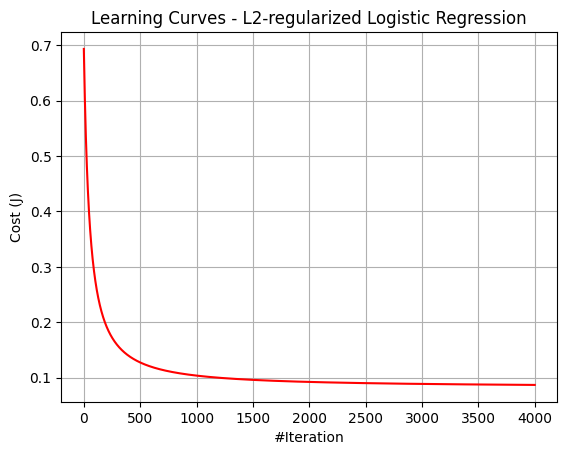

In [130]:
# Problem (h)
def compute_cost_l2(X, y, w, l):
    N = len(y)
    z = sigmoid(X @ w)
    epsilon = 1e-5

    logistic_loss = (1/N) * (((-y).T @ np.log(z + epsilon)) - ((1 - y).T @ np.log(1 - z + epsilon)))
    regularization_term = (l / (2 * N)) * np.sum(np.square(w))
    
    cost = logistic_loss + regularization_term
    return cost


def gradient_descent_l2(X, y, w, l, alpha, n_iters, threshold=1e-07):
    N = len(y)
    log_j = []
    j_last = np.Inf
    
    for i in range(n_iters):
        w_new = w - alpha*(-1/N * X.T @ (y-sigmoid(X @ w)) + l*w.sum())
        j_new = compute_cost_l2(X, y, w, l)
        
        if j_last - j_new < threshold:
            break
            
        w = w_new
        log_j.append(j_new)
        j_last = j_new

    return w, log_j


def train_logreg_l2(X_tr, y_tr, l, alpha, n_iters=1500):
    N_tr, d_tr = X_tr.shape
    
    X_tr_b = np.hstack((X_tr, np.ones((N_tr, 1))))
    w_init = np.zeros(d_tr + 1)
    
    initial_cost = compute_cost_l2(X_tr_b, y_tr, w_init, l)
    print("Initial J(w_init, D_tr) is: ", initial_cost, "\n")
    
    w_star, log_j = gradient_descent_l2(X_tr_b, y_tr, w_init, l, alpha, n_iters)
    
    print("w*: \n", w_star, "\n")
    print("J(w*, D_tr): ", log_j[-1])
    
    return w_star, log_j


def predict_logreg(X, w):
    N = X.shape[0]
    X_b = np.hstack((X, np.ones((N, 1))))
    y_prob = sigmoid(X_b @ w)
    y_pred = (y_prob >= 0.5).astype(int)
    
    return y_pred, y_prob

def get_accuracy(Y_true, Y_pred):
    """
    Measures the classification accuracy.
    Input: Y_true - true label vector (ground truth)
           Y_pred - predicted label vector
    return a floating point number representing accuracy
    """
    assert len(Y_true) == len(Y_pred)  # optional - assert makes sure a certain condition satisfies
    return np.sum(Y_true == Y_pred)/len(Y_true)
    
k=0
best_acc = 0
best_acc_train = 0
print(best_acc)
best_params = None
best_l = 0
best_alpha = 0
best_niters = 0
for l in [1e-5, 1e-4, 1e-3]: 
    for alpha in [0.001, 0.005, 0.01, 0.5, 1.0]: 
        for n_iters in [1000, 2000, 3000, 4000]:
            Model_logreg_l2, log_j_logreg_l2 = train_logreg_l2(X_tr, y_tr, l, alpha, n_iters)
            y_tr_pred, y_tr_prob = predict_logreg(X_tr, Model_logreg_l2)
            y_ts_pred, y_ts_prob = predict_logreg(X_ts, Model_logreg_l2)
    
            acc_tr = get_accuracy(y_tr, y_tr_pred)
            acc_ts = get_accuracy(y_ts, y_ts_pred)
            
            if (acc_tr != 1.0) and (acc_ts != 1.0) and (acc_ts >= best_acc) :
                if(acc_ts == best_acc):
                    if(a[-1]> log_j_logreg_l2[-1]):
                        best_acc = acc_ts
                        best_acc_train = acc_tr
                        best_params = {'l': l, 'alpha': alpha, 'n_iters': n_iters}
                        best_l = l
                        best_alpha = alpha
                        best_niters = n_iters
                        a = log_j_logreg_l2
                else:
                    best_acc = acc_ts
                    best_acc_train = acc_tr
                    best_params = {'l': l, 'alpha': alpha, 'n_iters': n_iters}
                    best_l = l
                    best_alpha = alpha
                    best_niters = n_iters
                    a = log_j_logreg_l2
            
print("best parameters:", best_params)
print("best lambda value :", best_l)
print("best alpha value :", best_alpha)
print("best n_iter value :", best_niters)
print("best accuracy(training):", best_acc_train)
print("best accuracy(testing):", best_acc)


import matplotlib.pyplot as plt

Model_logreg_l2_final, log_j_logreg_l2_fianl = train_logreg_l2(X_tr, y_tr, best_l, best_alpha, best_niters)
y_ts_pred, y_ts_prob = predict_logreg(X_ts, Model_logreg_l2_final)
acc_tr = get_accuracy(y_tr, y_tr_pred)
acc_ts = get_accuracy(y_ts, y_ts_pred)
print("training accuracy:", acc_tr)
print("best accuracy(testing):", acc_ts)

plt.plot(range(len(log_j_logreg_l2_fianl)), log_j_logreg_l2_fianl, 'r')
plt.title('Learning Curves - L2-regularized Logistic Regression')
plt.xlabel('#Iteration')
plt.ylabel('Cost (J)')
plt.grid(True)
plt.show()